<a href="https://colab.research.google.com/github/danhorsley/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Copy_of_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=61.30452817665607, mobile=True), User(purchased=True, time_on_site=111.73815641865316, mobile=True), User(purchased=False, time_on_site=299.07486646708156, mobile=True), User(purchased=False, time_on_site=42.25760390405415, mobile=True), User(purchased=False, time_on_site=18.871445138250717, mobile=True), User(purchased=True, time_on_site=167.9889197870982, mobile=True), User(purchased=False, time_on_site=268.7594056046024, mobile=True), User(purchased=False, time_on_site=200.9285331826206, mobile=True), User(purchased=False, time_on_site=310.66076483747105, mobile=False), User(purchased=True, time_on_site=130.05076923010367, mobile=True)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,61.304528,True
1,True,111.738156,True
2,False,299.074866,True
3,False,42.257604,True
4,False,18.871445,True


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.7655265431528875,7.239017216442127,8.054814687702798,8.20578296397905,8.309374965365782,8.787884321832115,9.965938534067082,10.024027886417118,10.17409585012259,10.186385918191437,...,578.5975552042327,580.1393919044759,582.4579702772173,585.0385252471177,586.5407693223568,586.6460549834352,590.504963340885,592.5941552473324,596.450639110221,597.3779092422527
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,1,1,1,1,0,1,0,...,1,1,0,0,0,1,1,0,0,0
True,0,1,0,0,0,0,0,1,0,1,...,0,0,1,1,1,0,0,1,1,1


In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.174, 124.088]","(124.088, 242.41]","(242.41, 360.733]","(360.733, 479.055]","(479.055, 597.378]"
purchased,,,,,
False,236,213,108,29,26
True,119,138,87,21,23


In [9]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.174, 124.088]","(124.088, 242.41]","(242.41, 360.733]","(360.733, 479.055]","(479.055, 597.378]"
purchased,,,,,
False,0.664789,0.606838,0.553846,0.58,0.530612
True,0.335211,0.393162,0.446154,0.42,0.469388


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [46]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

ct = pd.crosstab(user_data['mobile'],[user_data['purchased'],
                                 time_bins],rownames=['device'],colnames=['purchased','time_on_site'],normalize='index')
ct

purchased               False                                      \
time_on_site (5.174, 124.088] (124.088, 242.41] (242.41, 360.733]   
device                                                              
False                0.172000          0.124000          0.152000   
True                 0.257333          0.242667          0.093333   

purchased                                                     True   \
time_on_site (360.733, 479.055] (479.055, 597.378] (5.174, 124.088]   
device                                                                
False                     0.116              0.104         0.036000   
True                      0.000              0.000         0.146667   

purchased                                                            \
time_on_site (124.088, 242.41] (242.41, 360.733] (360.733, 479.055]   
device                                                                
False                    0.048             0.072              0.084   
True                     0.168             0.092              0.000   

purchased                        
time_on_site (479.055, 597.378]  
device                           
False                     0.092  
True                      0.000

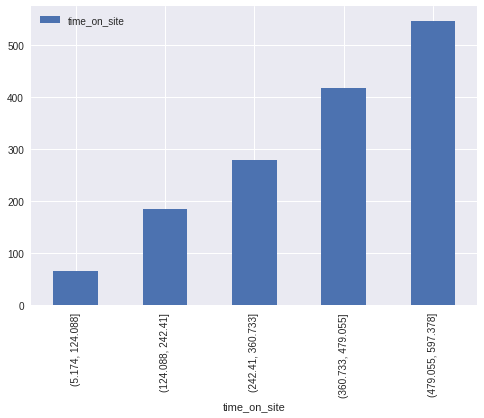

In [26]:
pd.pivot_table(user_data,values='time_on_site', index=time_bins).plot.bar()

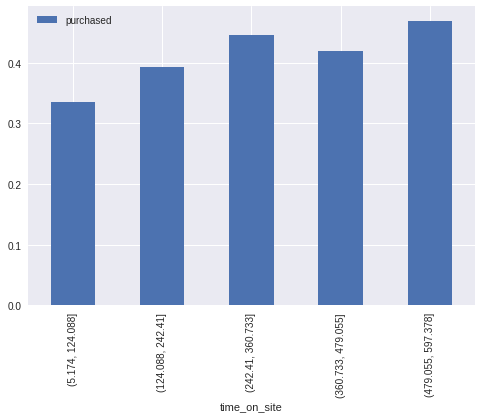

In [28]:
pd.pivot_table(user_data,values='purchased', index=time_bins).plot.bar()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa84344f4e0>,
      dtype=object)

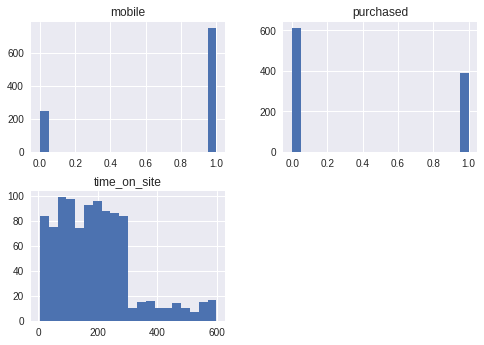

In [23]:
user_data.hist(bins=20)

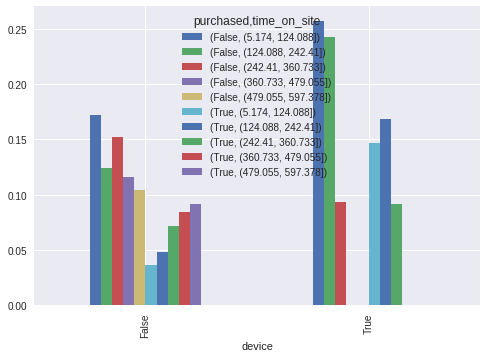

In [31]:
ct.plot(kind='bar')

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [42]:
dfn = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
dfn=dfn.drop('Unnamed: 0',axis=1)
dfn.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa83fecee48>,
      dtype=object)

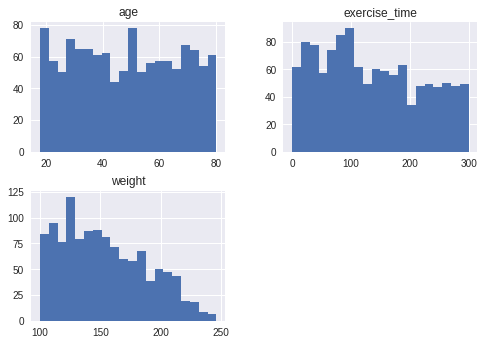

In [55]:
dfn.hist(bins=20)

In [95]:
age_bin = pd.cut(dfn['age'], 10)  # 10 equal-sized bins
exercise_bin = pd.cut(dfn['exercise_time'], 10)  # 10 equal-sized bins
weight_bin = pd.cut(dfn['weight'], 10)  # 10 equal-sized bins
ctn = pd.crosstab(age_bin,[weight_bin,exercise_bin],
                  rownames=['age'],colnames=['weight','exercise_time'],normalize='index')
ctn.head()

weight         (99.854, 114.6]                                          \
exercise_time     (-0.3, 30.0] (30.0, 60.0] (60.0, 90.0] (90.0, 120.0]   
age                                                                      
(17.938, 24.2]        0.000000     0.014815     0.007407      0.007407   
(24.2, 30.4]          0.000000     0.016529     0.008264      0.008264   
(30.4, 36.6]          0.007692     0.007692     0.000000      0.007692   
(36.6, 42.8]          0.008130     0.000000     0.024390      0.024390   
(42.8, 49.0]          0.008547     0.000000     0.008547      0.000000   

weight                                                                      \
exercise_time  (120.0, 150.0] (150.0, 180.0] (180.0, 210.0] (210.0, 240.0]   
age                                                                          
(17.938, 24.2]       0.014815       0.029630       0.022222       0.014815   
(24.2, 30.4]         0.024793       0.024793       0.008264       0.041322   
(30.4, 36.6]         0.000000       0.023077       0.030769       0.015385   
(36.6, 42.8]         0.016260       0.032520       0.016260       0.032520   
(42.8, 49.0]         0.008547       0.000000       0.025641       0.008547   

weight                                            ...       (231.4, 246.0]  \
exercise_time  (240.0, 270.0] (270.0, 300.0]      ...         (-0.3, 30.0]   
age                                               ...                        
(17.938, 24.2]       0.014815       0.014815      ...             0.014815   
(24.2, 30.4]         0.024793       0.033058      ...             0.000000   
(30.4, 36.6]         0.015385       0.038462      ...             0.000000   
(36.6, 42.8]         0.016260       0.048780      ...             0.008130   
(42.8, 49.0]         0.042735       0.017094      ...             0.025641   

weight                                                                 \
exercise_time  (30.0, 60.0] (60.0, 90.0] (90.0, 120.0] (120.0, 150.0]   
age                                                                     
(17.938, 24.2]     0.007407          0.0           0.0            0.0   
(24.2, 30.4]       0.000000          0.0           0.0            0.0   
(30.4, 36.6]       0.000000          0.0           0.0            0.0   
(36.6, 42.8]       0.000000          0.0           0.0            0.0   
(42.8, 49.0]       0.000000          0.0           0.0            0.0   

weight                                                                      \
exercise_time  (150.0, 180.0] (180.0, 210.0] (210.0, 240.0] (240.0, 270.0]   
age                                                                          
(17.938, 24.2]            0.0            0.0            0.0            0.0   
(24.2, 30.4]              0.0            0.0            0.0            0.0   
(30.4, 36.6]              0.0            0.0            0.0            0.0   
(36.6, 42.8]              0.0            0.0            0.0            0.0   
(42.8, 49.0]              0.0            0.0            0.0            0.0   

weight                         
exercise_time  (270.0, 300.0]  
age                            
(17.938, 24.2]            0.0  
(24.2, 30.4]              0.0  
(30.4, 36.6]              0.0  
(36.6, 42.8]              0.0  
(42.8, 49.0]              0.0  

[5 rows x 100 columns]

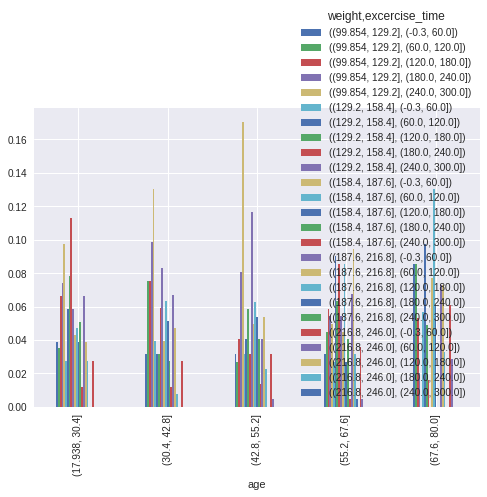

In [54]:
ctn.plot(kind='bar')

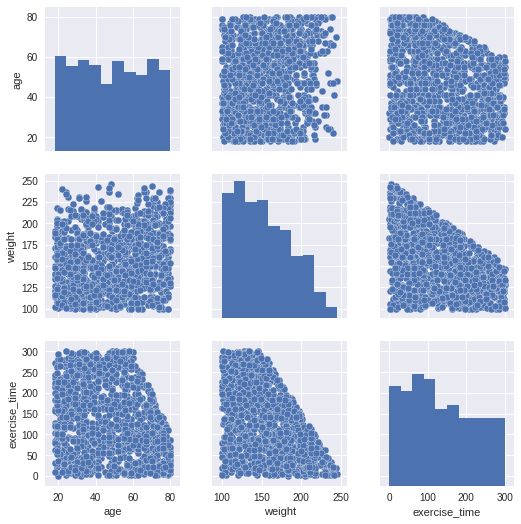

In [57]:
import seaborn as sns
g = sns.pairplot(dfn)

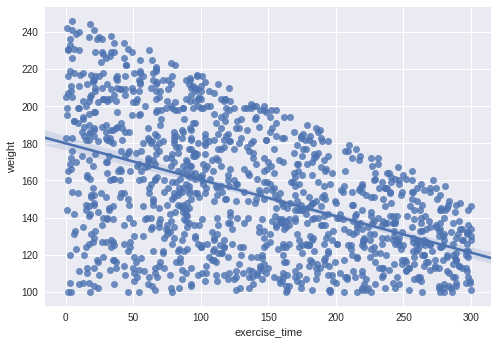

In [83]:
#pairplot seems to suggest as excercise time goes down, weight increases
#also as age goes higher excercise time seems to go down
ax_w_e = sns.regplot(x="exercise_time", y="weight", data=dfn)

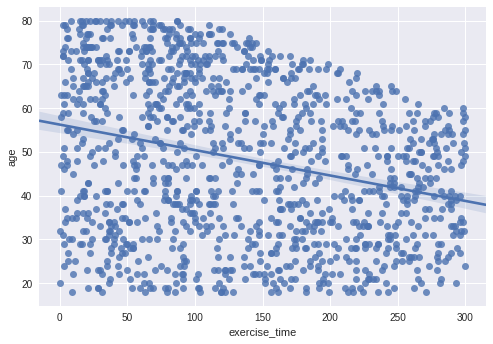

In [84]:
#age vs excercise time
ax_a_e = sns.regplot(x="exercise_time", y="age", data=dfn)

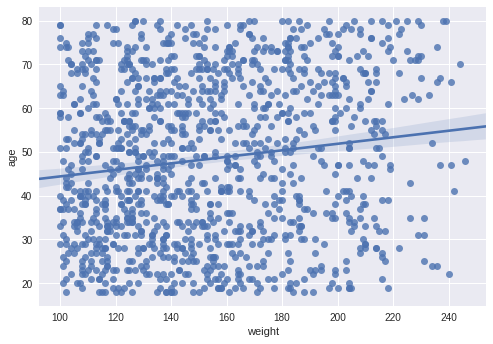

In [85]:
#weight vs age
ax_a_w = sns.regplot(x="weight", y="age", data=dfn)

In [87]:
from sklearn.linear_model import LinearRegression
X=dfn['exercise_time'].reshape(-1, 1)
y=dfn['weight'].reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y), reg.coef_, reg.intercept_ 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


(0.22850439235424755, array([[-0.196308]]), array([180.02490926]))

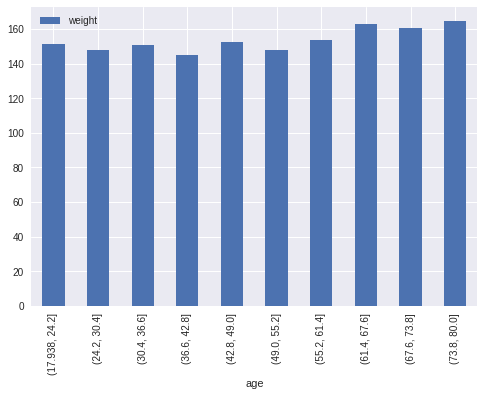

In [96]:
pd.pivot_table(dfn,values='weight', index=age_bin).plot.bar()

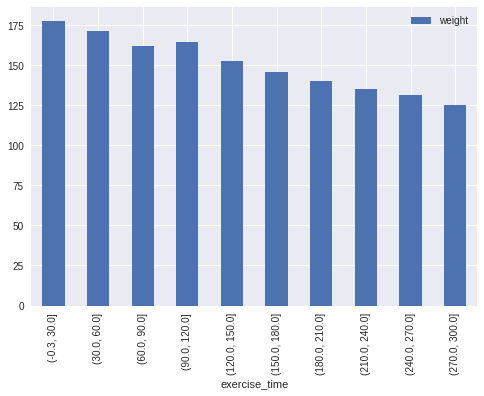

In [97]:
pd.pivot_table(dfn,values='weight', index=exercise_bin).plot.bar()

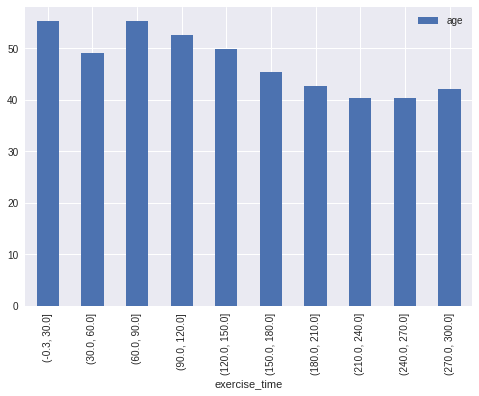

In [98]:
pd.pivot_table(dfn,values='age', index=exercise_bin).plot.bar()

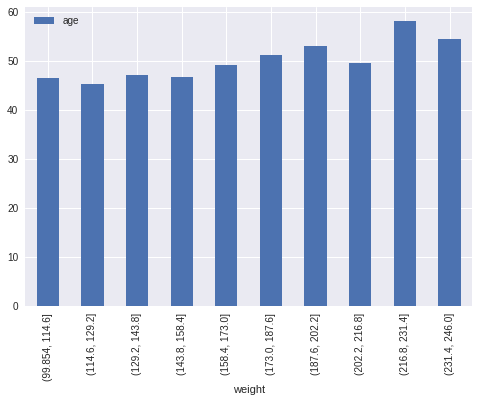

In [99]:
pd.pivot_table(dfn,values='age', index=weight_bin).plot.bar()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

weight, age and exercise time.  all are given as integers, though there is enough variety so we can consider them continuous

2.  What are the relationships between the variables?

as exercise time goes up, weight goes down

as age goes up, exercise time goes down

as age goes up, weight goes up



3.  Which relationships are "real", and which spurious?

the real relationships are excercise time up, weight going down and exercise time going down as age goes down

the spurious relationship is weight going up as age goes up.  this only arises as you move less as you get older so your exercise time goes down, causign your weight to go up


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)